# MDP Wavelet

In [1]:
import os
import time
import matplotlib.pyplot as plt
#%matplotlib notebookimport os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchvision.models as torch_models
import torch.utils.model_zoo as model_zoo

from PIL import Image
from torchvision import transforms as T

from pytorch_wavelets import IDWT

In [2]:
from networks.decoders import DepthWaveProgressiveDecoder, SparseDepthWaveProgressiveDecoder
from networks.encoders import *

## Build Network

In [3]:
class DenseModel(nn.Module):
    def __init__(self, num_layers, output_scales, device="cpu"):
        super(DenseModel, self).__init__()
        device = torch.device("cpu" if device=="cpu" else "cuda")
        self.models = {}
        self.models["encoder"] = ResnetEncoder(num_layers, False)
        self.models["depth"] = DepthWaveProgressiveDecoder(
                        self.models["encoder"].num_ch_enc, scales=output_scales)       
        
        self.models["encoder"].to(device)
        self.models["depth"].to(device)
    
    def forward(self, x):
        features_encoder = self.models["encoder"](x)
        outputs = self.models["depth"](features_encoder)
        return outputs

    
class SparseModel(nn.Module):
    def __init__(self, num_layers, output_scales, sparse_scales, device="cpu"):
        super(SparseModel, self).__init__()
        device = torch.device("cpu" if device=="cpu" else "cuda")
        self.models = {}
        self.models["encoder"] = ResnetEncoder(num_layers, False)
        self.models["depth"] = SparseDepthWaveProgressiveDecoder(
                        self.models["encoder"].num_ch_enc, scales=output_scales)       
        
        self.models["encoder"].to(device)
        self.models["depth"].to(device)
        self.sparse_scales = sparse_scales
    
    def forward(self, x, thresh_ratio):
        features_encoder = self.models["encoder"](x)
        outputs = self.models["depth"](features_encoder, thresh_ratio, sparse_scales)
        return outputs
        

In [4]:
# Encoder Parameters
num_layers = 50

# Decoder Parameters
output_scales = [0, 1, 2, 3]
sparse_scales = [0, 1, 2, 3]

device = "cpu"

dense_model = DenseModel(num_layers, output_scales, device=device)
dense_model.eval()
sparse_model = SparseModel(num_layers, output_scales, sparse_scales, device=device)
sparse_model.eval()

SparseModel()

In [5]:
def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

## load weights, set to eval()

In [6]:
models_to_load = ["encoder", "depth"]

def load_model(model, load_weights_folder):
    """Load model(s) from disk
    """
    load_weights_folder = os.path.expanduser(load_weights_folder)

    assert os.path.isdir(load_weights_folder), \
        "Cannot find folder {}".format(load_weights_folder)
    print("loading model from folder {}".format(load_weights_folder))    

    for n in models_to_load:
        print("Loading {} weights...".format(n))
        path = os.path.join(load_weights_folder, "{}.pth".format(n))
        model_dict = model.models[n].state_dict()
        pretrained_dict = torch.load(path, map_location={"cuda:0": "cpu"})
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.models[n].load_state_dict(model_dict)    

In [7]:
model_path = "HR_Res50"

print("Loading weights for Dense model")
load_model(dense_model, model_path)
dense_model.models["encoder"].eval()
print("Done")

print("Loading weights for Sparse model")
load_model(sparse_model, model_path)
sparse_model.models["encoder"].eval()
print("Done")

Loading weights for Dense model
loading model from folder HR_Res50
Loading encoder weights...
Loading depth weights...
Done
Loading weights for Sparse model
loading model from folder HR_Res50
Loading encoder weights...
Loading depth weights...
Done


# Test!

In [15]:
#image_path = "../assets/kitti_test_sample.jpg"
image_path = "../../datasets/hallway_test.png"


to_tensor = T.ToTensor()
resize = T.Resize((320, 1024), interpolation=T.InterpolationMode.BILINEAR, antialias=True)
nnresize = T.Resize((320, 1024), interpolation=T.InterpolationMode.NEAREST)

img = Image.open(image_path)
def to_torch(img):
    img_tensor = to_tensor(resize(img)).unsqueeze(0)
    return img_tensor

img_tensor = to_torch(img)
if device=="cuda":
    img_tensor = img_tensor.cuda()

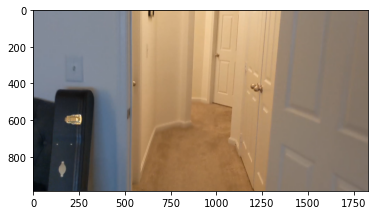

In [16]:
plt.figure()
plt.imshow(img)

In [17]:
threshold = 0.05
with torch.no_grad():    
    sparse_outputs = sparse_model(img_tensor, thresh_ratio=-1)
    total_ops_dense = sparse_outputs["total_ops"]
    sparse_outputs = sparse_model(img_tensor, thresh_ratio=threshold)    

sparse: 3
sparse: 2
sparse: 1
sparse: 3
sparse: 2
sparse: 1


### Profiling 

In [18]:
from thop import profile, clever_format
from ptflops import get_model_complexity_info

with torch.no_grad():
    feature_maps = dense_model.models["encoder"](img_tensor)
    dense_macs_decoder, _ = profile(dense_model.models["depth"], inputs=(feature_maps, ))

[WARN] Cannot find rule for <class 'pytorch_wavelets.dwt.transform2d.DWTInverse'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.padding.ReflectionPad2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'layers.Conv3x3'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.ELU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.linear.Identity'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'layers.ConvBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'layers.Conv1x1'>. Treat it as zero Macs and zero Params.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs a

In [19]:
print("{:<40} {:<8}".format("Dense operations", "GFLOPs"))
print("{:<40} {:.3f}".format("Decoder (thops) ", dense_macs_decoder / 10**9))
print("{:<40} {:.3f}".format("Decoder (sparse_conv, thresh<0) ", total_ops_dense / 10**9))

print("="*37)
print("{:<40} {:<8}".format("Wavelets version operations", "GFLOPs"))
print("{:<40} {:.3f}".format("Sparse operations ", sparse_outputs['total_ops'] / 10**9))

Dense operations                         GFLOPs  
Decoder (thops)                          17.217
Decoder (sparse_conv, thresh<0)          17.474
Wavelets version operations              GFLOPs  
Sparse operations                        6.009


# Visualization

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(11, 4))

fig.tight_layout()

def set_left_title(title):
    ax = plt.gca()
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
    plt.tick_params(axis = "y", which = "both", left = False, right = False)
    plt.ylabel(title)
    plt.box(on=None)

wave_range = 0.1
for i in range(4):
    #plt.subplot(5, 4, 1+i)
    #plt.imshow(sparse_outputs[('wavelet_mask', 3-i)][0,0])
    plt.title("Scale 1/{}".format(2**(3-i+1)))
    #plt.clim(0, 1)    
    #if i==0:
    #    set_left_title("Mask")
    #else:
    #    plt.axis("off")

    #coeffs = ["LH", "HL", "HH"]
    #for j in range(3):
    #    plt.subplot(5,4,1+(4*j)+4+i)
    #    plt.imshow(sparse_outputs[("wavelets", 3-i, coeffs[j])][0,0],
    #               vmin=-wave_range/(2**i), vmax = wave_range/(2**i),
    #               cmap='gray')        
    #    if i==0:
    #        set_left_title(coeffs[j])
    #    else:
    #        plt.axis("off")
    #plt.subplot(5, 4, 17+i)
    plt.subplot(5, 4, 1+i)
    pred = sparse_outputs[('disp', 3-i)][0,0].numpy()/100
    disp = pred
    plt.imshow(disp, cmap="inferno", vmin = np.percentile(disp, 1), vmax = np.percentile(disp, 99))
    if i==0:
        set_left_title("depth")
    else:
        plt.axis("off")
    
fig.subplots_adjust(wspace=0.05, hspace=0)
